In [1]:
import json
import pandas as pd
import numpy as np
import re
import requests
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point
import geopandas as gpd
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [2]:
#violations.csv loaded after being cleaned in phase 1

violations = pd.read_csv('../data/violations.csv')

In [3]:
violations.head()

date_time_opened  case_number  status      case_subrequest  \
0  2020-11-06 21:51:48       497464     New  COVID-19 Violations   
1  2020-11-07 05:07:43       497626     New  COVID-19 Violations   
2  2020-11-06 02:05:43       496725  Closed  COVID-19 Violations   
3  2020-11-06 04:19:04       496741  Closed  COVID-19 Violations   
4  2020-11-05 16:18:39       496042  Closed  COVID-19 Violations   

              case_origin  closed_when_created    incident_address  \
0  hubNashville Community                False      301 14th Ave N   
1  hubNashville Community                False       1531 Broadway   
2  hubNashville Community                False        401 Union St   
3  hubNashville Community                False     81 Van Buren St   
4                   Phone                False  3204 Gallatin Pike   

  incident_city  incident_council_district  incident_zip_code   latitude  \
0     NASHVILLE                       19.0            37203.0  36.159251   
1     NASHVILLE                       19.0            37203.0  36.154065   
2     NASHVILLE                       19.0            37219.0  36.164800   
3     NASHVILLE                       19.0            37208.0  36.181791   
4     NASHVILLE                        7.0            37216.0  36.205640   

   longitude                                    mapped_location  \
0 -86.793243  {'latitude': '36.15925116160531', 'longitude':...   
1 -86.792344  {'latitude': '36.1540647', 'longitude': '-86.7...   
2 -86.779929  {'latitude': '36.16480010000001', 'longitude':...   
3 -86.784818  {'latitude': '36.181790734428645', 'longitude'...   
4 -86.735940  {'latitude': '36.20564', 'longitude': '-86.735...   

          date_time_closed contact_type  parent_case  
0                      NaN          NaN          NaN  
1                      NaN          NaN          NaN  
2  2020-11-06T14:42:04.000          NaN          NaN  
3  2020-11-06T14:35:14.000          NaN          NaN  
4  2020-11-06T14:38:31.000          NaN          NaN

In [4]:
#dropped rows with empty gps coordinates as they will cause errors later

violations = violations.dropna(subset = ['latitude'])

In [5]:
#Lambda function to create a column that can be used to assign geometry 

violations['geometry'] = violations.apply(lambda x: Point((float(x.longitude), 
                                                          float(x.latitude))), axis = 1)
violations.head()

date_time_opened  case_number  status      case_subrequest  \
0  2020-11-06 21:51:48       497464     New  COVID-19 Violations   
1  2020-11-07 05:07:43       497626     New  COVID-19 Violations   
2  2020-11-06 02:05:43       496725  Closed  COVID-19 Violations   
3  2020-11-06 04:19:04       496741  Closed  COVID-19 Violations   
4  2020-11-05 16:18:39       496042  Closed  COVID-19 Violations   

              case_origin  closed_when_created    incident_address  \
0  hubNashville Community                False      301 14th Ave N   
1  hubNashville Community                False       1531 Broadway   
2  hubNashville Community                False        401 Union St   
3  hubNashville Community                False     81 Van Buren St   
4                   Phone                False  3204 Gallatin Pike   

  incident_city  incident_council_district  incident_zip_code   latitude  \
0     NASHVILLE                       19.0            37203.0  36.159251   
1     NASHVILLE                       19.0            37203.0  36.154065   
2     NASHVILLE                       19.0            37219.0  36.164800   
3     NASHVILLE                       19.0            37208.0  36.181791   
4     NASHVILLE                        7.0            37216.0  36.205640   

   longitude                                    mapped_location  \
0 -86.793243  {'latitude': '36.15925116160531', 'longitude':...   
1 -86.792344  {'latitude': '36.1540647', 'longitude': '-86.7...   
2 -86.779929  {'latitude': '36.16480010000001', 'longitude':...   
3 -86.784818  {'latitude': '36.181790734428645', 'longitude'...   
4 -86.735940  {'latitude': '36.20564', 'longitude': '-86.735...   

          date_time_closed contact_type  parent_case  \
0                      NaN          NaN          NaN   
1                      NaN          NaN          NaN   
2  2020-11-06T14:42:04.000          NaN          NaN   
3  2020-11-06T14:35:14.000          NaN          NaN   
4  2020-11-06T14:38:31.000          NaN          NaN   

                                       geometry  
0        POINT (-86.79324305 36.15925116160531)  
1          POINT (-86.792344 36.15406470000001)  
2         POINT (-86.7799287 36.16480010000001)  
3  POINT (-86.78481795092623 36.18179073442865)  
4                    POINT (-86.73594 36.20564)

In [6]:
#Exploration to see if the data has clean gps coordinates...it does not

violations.longitude.sort_values()

4629   -118.318279
9515   -104.979529
3874    -97.004120
1815    -96.983184
8146    -94.005701
           ...    
4878    -76.955058
1980     11.249255
1952     11.249255
1951     11.468288
1970     19.209794
Name: longitude, Length: 11398, dtype: float64

In [7]:
#Again, min and maxes are well outside of metro

violations.longitude.describe()

count    11398.000000
mean       -86.719133
std          1.932298
min       -118.318279
25%        -86.799776
50%        -86.772787
75%        -86.704480
max         19.209794
Name: longitude, dtype: float64

In [8]:
#Boundary file for mapping

metro = gpd.read_file('../data/Davidson County Border.geojson')

In [9]:
#Checking to ensure the boundary files coordinate system is in place

metro.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
#Created a geopandas data frame with a coordinate system matched to the metro boundary file

violations_geo = gpd.GeoDataFrame(violations, crs = metro.crs, geometry = violations['geometry'])

In [11]:
#Verifying the coordination system 

violations_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

(35.945865086682986, 36.4275882606404)

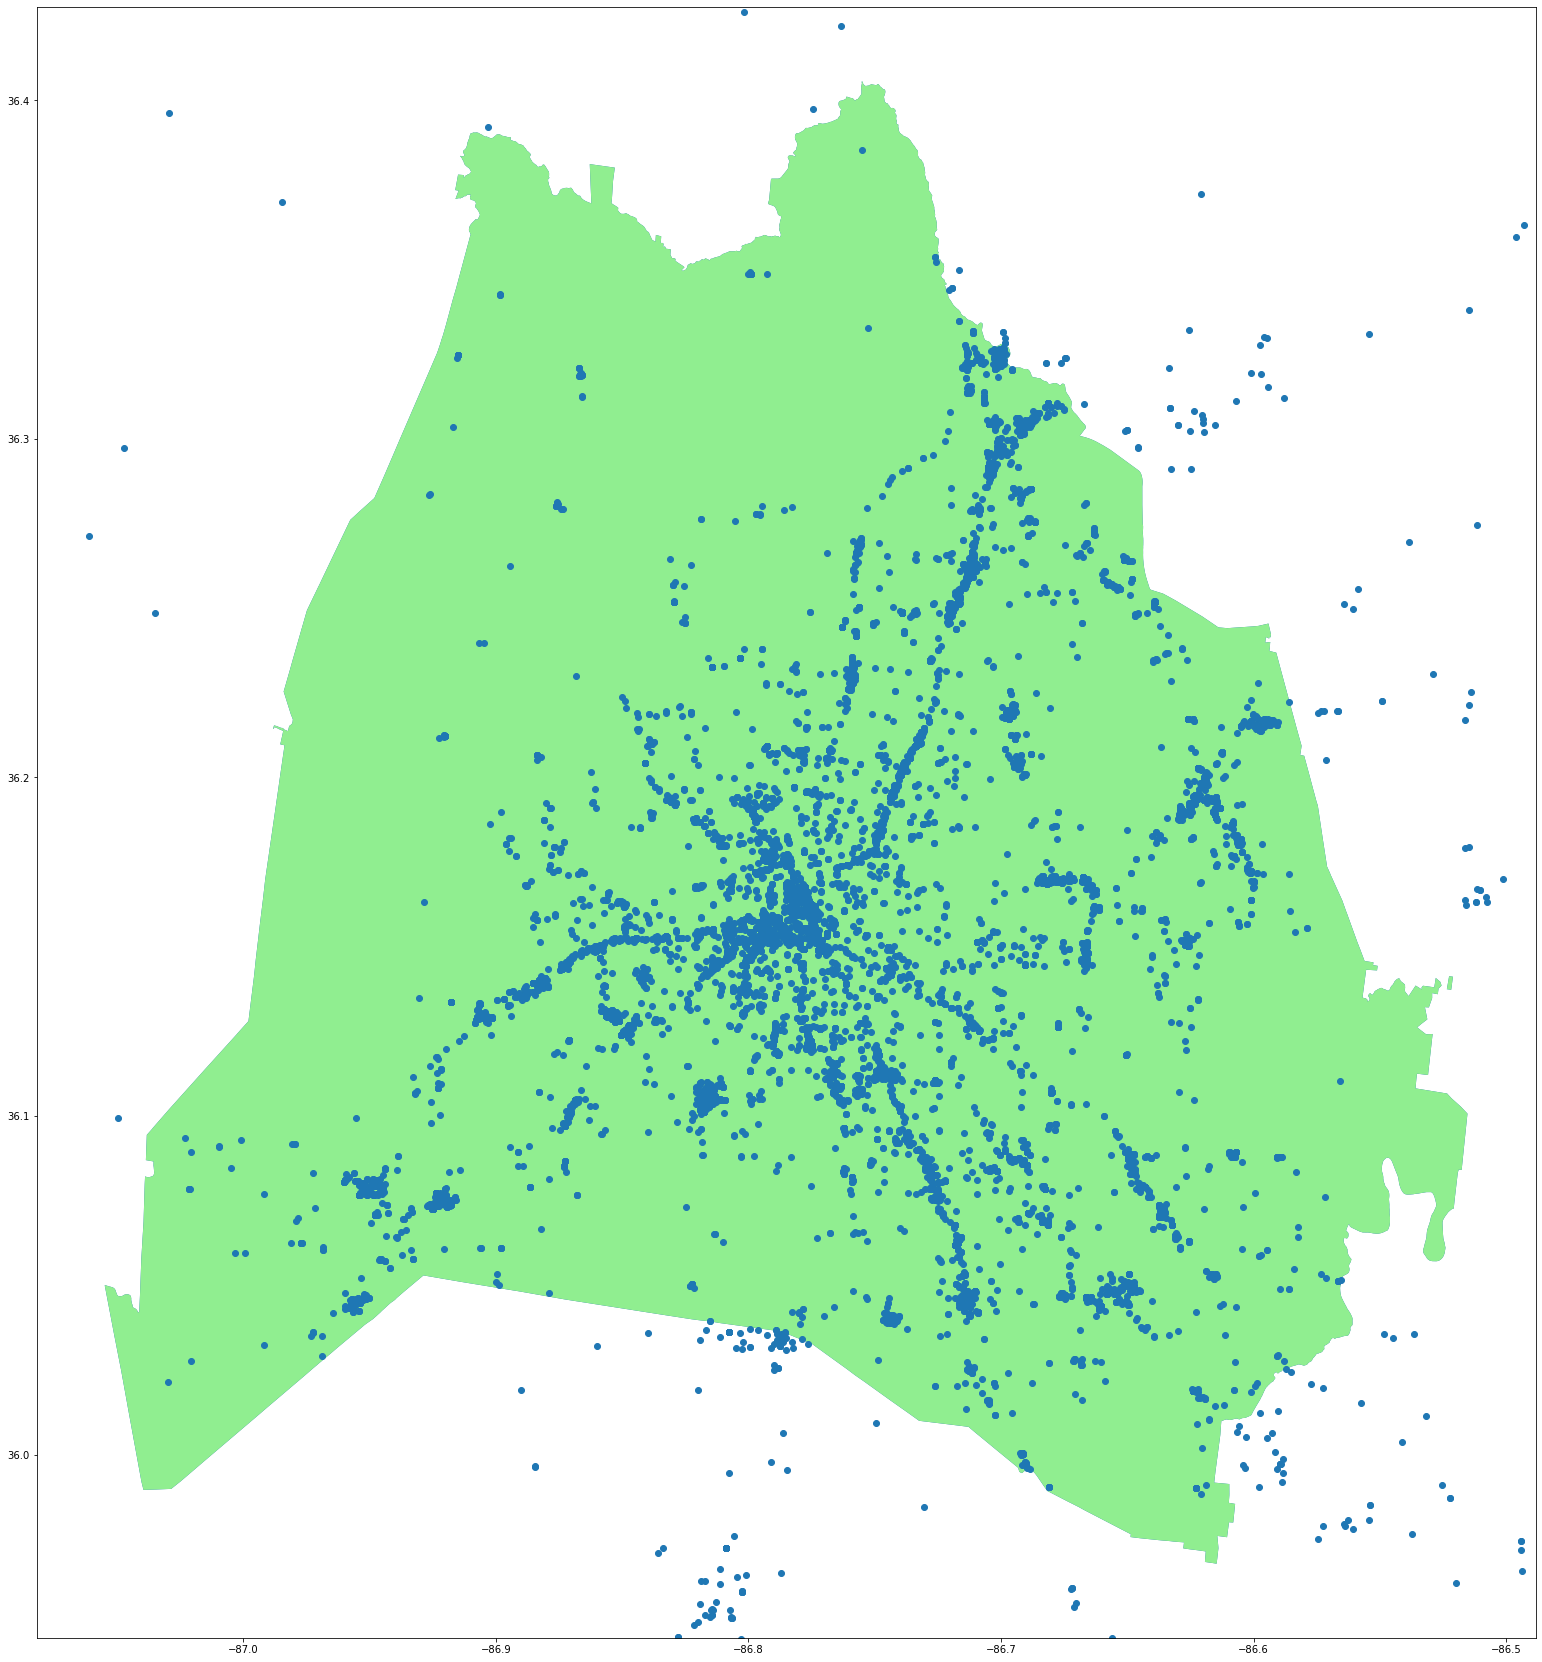

In [12]:
#Basic map plot of the data

ax = metro.plot(figsize = (30,30))

metro.plot(ax = ax, color = 'lightgreen')

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

violations_geo.plot(ax = ax)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

In [13]:
violations_geo.geometry

0        POINT (-86.79324 36.15925)
1        POINT (-86.79234 36.15406)
2        POINT (-86.77993 36.16480)
3        POINT (-86.78482 36.18179)
4        POINT (-86.73594 36.20564)
                    ...            
11643    POINT (-86.80076 36.14702)
11644    POINT (-86.62000 36.19871)
11648    POINT (-86.79741 36.17220)
11665    POINT (-86.94391 36.08447)
11671    POINT (-86.75806 36.22890)
Name: geometry, Length: 11398, dtype: geometry

In [14]:
#Checking to see if the file has multiple centeroids, it does! Normally this would require some sort of checking to see which
#point is actually the centroid. Extra centroids are a result of a non-contiguous, multi-part polygon. If one looks at the map
#displayed in prior, their is a small 'island' just off of the east side of Davidson County. 

metro.geometry.centroid

<ipython-input-14-838558b05012>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  metro.geometry.centroid


0    POINT (-86.78493 36.16952)
1    POINT (-86.52221 36.13925)
dtype: geometry

In [15]:
#Establishing centroid for folium

center = metro.geometry.centroid[0]

<ipython-input-15-3c56a8dfce55>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = metro.geometry.centroid[0]


In [16]:
area_center = [center.y, center.x]

In [17]:
#Creating a map for exploration purposes

map_temp = folium.Map(location = area_center, zoom_start = 10)

In [18]:
#Adds the metro boundary to the folium map

folium.GeoJson(metro).add_to(map_temp)

In [19]:
#Creates the marker clusters

marker_cluster = MarkerCluster().add_to(map_temp)

for row_index, row_values in violations_geo.iterrows():
    loc = [row_values['latitude'], row_values['longitude']]
    pop = folium.Popup(html = str(row_values['incident_address']), min_width = 100, max_width = 250)
    marker = folium.Marker(
    location = loc,
    popup = pop, 
    icon = folium.Icon(color = 'red', icon = 'bullseye', prefix = 'fa'))
    
    marker.add_to(marker_cluster)

In [20]:
#Load's Courtney's fuzzy matched df

top_results = pd.read_csv('../data/top_results.csv')

In [21]:
#map_temp

#Commented out so as not to load on kernal reload

In [22]:
top_results

Unnamed: 0                          violation_coord  \
0              0                (36.0685457, -86.6838975)   
1              5  (36.211269429469425, -86.6943024067459)   
2             10                     (36.1235, -86.79013)   
3             15                (36.1941628, -86.8313936)   
4             20   (36.15843971160494, -86.7880380629013)   
...          ...                                      ...   
4819       24120                     (36.25852, -86.7583)   
4820       24125        (36.153299711602756, -86.7960281)   
4821       24130                     (36.18837, -86.7676)   
4822       24135                (36.1458305, -86.8167581)   
4823       24140  (36.08778474206125, -86.72961779427743)   

                      violation_address business_status  \
0            2045 Antioch Pike, Antioch     OPERATIONAL   
1        2800 Opryland Drive, Nashville     OPERATIONAL   
2     2607 12th Avenue South, Nashville     OPERATIONAL   
3      3200 Clarksville Pike, Nashville     OPERATIONAL   
4           20 Grundy Street, Nashville     OPERATIONAL   
...                                 ...             ...   
4819     3638 Dickerson Pike, Nashville     OPERATIONAL   
4820    1722 West End Avenue, Nashville     OPERATIONAL   
4821    1001 Meridian Street, Nashville     OPERATIONAL   
4822   221 31st Avenue North, Nashville     OPERATIONAL   
4823   3806 Nolensville Pike, Nashville     OPERATIONAL   

                           name                       google_address  \
0                  Los Paisanos           2045 Antioch Pike, Antioch   
1        Best Buy Express Kiosk       2800 Opryland Drive, Nashville   
2            White Bison Coffee    2607 12th Avenue South, Nashville   
3              TIGERMARKET #203  3200 Clarksville Highway, Nashville   
4              Baldwin Showcase             Grundy Street, Nashville   
...                         ...                                  ...   
4819       Mid-Tenn Sheet Metal       3638 Dickerson Pike, Nashville   
4820               Golden Coast      1722 West End Avenue, Nashville   
4821  North Edgefield Organized       914 Meridian Street, Nashville   
4822  31st Ave N & Burch Ave NB                        United States   
4823         Bucanas Night Club     3810 Nolensville Pike, Nashville   

      google_lat  google_lng              icon  match_ratio  \
0      36.068546  -86.683898               bar          100   
1      36.211414  -86.694149  generic_business          100   
2      36.123453  -86.790115              cafe          100   
3      36.194220  -86.831207       gas_station           87   
4      36.158366  -86.787996  generic_business           94   
...          ...         ...               ...          ...   
4819   36.258571  -86.758322  generic_business          100   
4820   36.153296  -86.796024        restaurant          100   
4821   36.188152  -86.768248  generic_business           92   
4822   36.146209  -86.816324  generic_business           27   
4823   36.087799  -86.729576               bar           97   

           location_type  
0             night_club  
1      point_of_interest  
2      convenience_store  
3            gas_station  
4      point_of_interest  
...                  ...  
4819  general_contractor  
4820          restaurant  
4821   point_of_interest  
4822     transit_station  
4823          night_club  

[4824 rows x 11 columns]

In [23]:
#A repeat of the steps completed for map_temp and violations_geo

top_results['geometry'] = top_results.apply(lambda x: Point((float(x.google_lng), 
                                                          float(x.google_lat))), axis = 1)

In [24]:
top_results_geo = gpd.GeoDataFrame(top_results, crs = metro.crs, geometry = violations['geometry'])

In [25]:
top_results_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
map_final = folium.Map(location = area_center, zoom_start = 10)

In [27]:
folium.GeoJson(metro).add_to(map_final)

In [28]:
#Includes multiple columns of information per row/tooltip
#Includes style changes, color, icon, and popup size
#Also include geo df row number as output so they can be conviently checked with an iloc

marker_cluster = MarkerCluster().add_to(map_final)

for row_index, row_values in top_results_geo.iterrows():
    loc = [row_values['google_lat'], row_values['google_lng']]
    pop = folium.Popup(html = 'Business: '
                       + str(row_values['name']) 
                       + '<br>Match Ratio: ' 
                       + str(row_values['match_ratio'])
                       + '<br>Address: '
                       + str(row_values['violation_address'])
                       + '<br>GeoDateFrame Row: '
                       + str(row_values.name),
    min_width = 100, max_width = 250)
    marker = folium.Marker(
    location = loc,
    popup = pop, 
    icon = folium.Icon(color = 'red', icon = 'hand-o-left', prefix = 'fa'))
    
    marker.add_to(marker_cluster)
    
#str(yourdata) + ':' +str(otherdata)

In [29]:
#Final map. 

map_final

In [1]:
#top_results_geo.iloc[3936]

In [2]:
#top_results_geo.iloc[4056]

In [32]:
temp = violations['incident_address'] == 'Unnamed Road'

violations[temp]

date_time_opened  case_number  status      case_subrequest  \
1952   2020-08-20 19:47:22       449284  Closed  COVID-19 Violations   
1980   2020-08-20 16:53:01       449085  Closed  COVID-19 Violations   
5168   2020-07-11 03:40:05       413824  Closed  COVID-19 Violations   
6022   2020-07-05 20:05:30       407982  Closed  COVID-19 Violations   
6042   2020-07-03 20:46:52       407358  Closed  COVID-19 Violations   
8641   2020-05-14 14:57:32       367436  Closed  COVID-19 Violations   
10255  2020-04-05 18:50:44       339632  Closed  COVID-19 Violations   
10706  2020-04-05 19:45:15       339656  Closed  COVID-19 Violations   

                  case_origin  closed_when_created incident_address  \
1952   hubNashville Community                False     Unnamed Road   
1980   hubNashville Community                False     Unnamed Road   
5168   hubNashville Community                False     Unnamed Road   
6022   hubNashville Community                False     Unnamed Road   
6042   hubNashville Community                False     Unnamed Road   
8641   hubNashville Community                False     Unnamed Road   
10255  hubNashville Community                False     Unnamed Road   
10706  hubNashville Community                False     Unnamed Road   

      incident_city  incident_council_district  incident_zip_code   latitude  \
1952            NaN                        NaN                NaN  51.021271   
1980            NaN                        NaN                NaN  51.021271   
5168      NASHVILLE                       35.0            37209.0  36.131354   
6022      NASHVILLE                       35.0            37209.0  36.131385   
6042      BRENTWOOD                        4.0            37027.0  35.997018   
8641      NASHVILLE                        2.0            37228.0  36.191451   
10255     NASHVILLE                       19.0            37219.0  36.167205   
10706       ANTIOCH                       32.0            37013.0  36.049278   

       longitude                                    mapped_location  \
1952   11.249255  {'latitude': '51.02127149332476', 'longitude':...   
1980   11.249255  {'latitude': '51.02127149332476', 'longitude':...   
5168  -86.906982  {'latitude': '36.13135359178711', 'longitude':...   
6022  -86.906997  {'latitude': '36.131384811593456', 'longitude'...   
6042  -86.691576  {'latitude': '35.9970180447762', 'longitude': ...   
8641  -86.791888  {'latitude': '36.19145111279455', 'longitude':...   
10255 -86.785157  {'latitude': '36.16720530833453', 'longitude':...   
10706 -86.657238  {'latitude': '36.04927788546219', 'longitude':...   

              date_time_closed contact_type  parent_case  \
1952   2020-08-21T13:36:29.000          NaN          NaN   
1980   2020-08-21T13:39:02.000          NaN          NaN   
5168   2020-07-13T18:56:27.000          NaN          NaN   
6022   2020-07-06T17:46:07.000          NaN          NaN   
6042   2020-07-06T17:37:30.000          NaN          NaN   
8641   2020-05-15T19:29:40.000          NaN          NaN   
10255  2020-04-14T15:38:09.000          NaN          NaN   
10706  2020-04-13T15:53:22.000          NaN          NaN   

                         geometry  
1952    POINT (11.24925 51.02127)  
1980    POINT (11.24925 51.02127)  
5168   POINT (-86.90698 36.13135)  
6022   POINT (-86.90700 36.13138)  
6042   POINT (-86.69158 35.99702)  
8641   POINT (-86.79189 36.19145)  
10255  POINT (-86.78516 36.16721)  
10706  POINT (-86.65724 36.04928)

In [33]:
temp

0        False
1        False
2        False
3        False
4        False
         ...  
11643    False
11644    False
11648    False
11665    False
11671    False
Name: incident_address, Length: 11398, dtype: bool

In [34]:
violations_geo.iloc[0]

date_time_opened                                           2020-11-06 21:51:48
case_number                                                             497464
status                                                                     New
case_subrequest                                            COVID-19 Violations
case_origin                                             hubNashville Community
closed_when_created                                                      False
incident_address                                                301 14th Ave N
incident_city                                                        NASHVILLE
incident_council_district                                                   19
incident_zip_code                                                        37203
latitude                                                               36.1593
longitude                                                             -86.7932
mapped_location              {'latitude': '36.159251

In [35]:
violations.iloc[6450]

date_time_opened                                        2020-06-27 11:19:05
case_number                                                          402199
status                                                               Closed
case_subrequest                                         COVID-19 Violations
case_origin                                          hubNashville Community
closed_when_created                                                   False
incident_address                                210 Anne Dallas Dudley Blvd
incident_city                                                     NASHVILLE
incident_council_district                                                19
incident_zip_code                                                     37219
latitude                                                             36.163
longitude                                                           -86.782
mapped_location              {'latitude': '36.163', 'longitude': '-86.782'}
date_time_cl